##### Fast Campus Data Science School 7th Team Project 1

# [Walmart : Sales in Stormy Weather](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather/leaderboard)

![image.png](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/walmart%20logo.png?raw=true)

# [ Overview ]

### (1) Team : Crawling
> - 김태형 [팀원]
> - 백윤아 [팀원]
> - 서웅국 [팀장]

### (2) Dataset : 
> #### Walmart Sales Data 

### (3) Objective : 
> #### Predict how sales of weather-sensitive products are affected by snow and rain

<br>

# [Data Description]

> #### train : 4617600 rows, 2 columns
> - sales data for all stores & dates in the training set

> #### test : 526917 rows, 2 columns
> - stores & dates for forecasting (missing 'units', which you must predict) 

> #### key : 45 rows, 2 columns
> - the relational mapping between stores and the weather stations that cover them

> #### weather : 20517 rows, 20 columns
> - a file containing the NOAA weather information for each station and day


| Index | Feature     | Description                                                         |
|-------|:-------------:|:---------------------------------------------------------------------:|
| 1     | units       | the quantity sold of an item on a given day (Target)                |
| 2     | date        | the day of sales or weather                                         |
| 3     | store_nbr   | an id representing one of the 45 stores                             |
| 4     | station_nbr | an id representing one of 20 weather stations                       |
| 5     | item_nbr    | an id representing one of the 111 products                          |
| 6     | tmax        | maximum degrees Fahrenheit                                          |
| 7     | tmin        | minimum degrees Fahrenheit                                          |
| 8     | tavg        | average degrees Fahrenheit                                          |
| 9     | depart      | departure from normal                                               |
| 10    | dewpoint    | average dew point                                                   |
| 11    | wetbulb     | average wet bulb                                                    |
| 12    | heat        | heating (season begins with July)                                   |
| 13    | cool        | cooling (season begins with January)                                |
| 14    | sunrise     | sunrise (calculated, not observed)                                  |
| 15    | sunset      | sunset (calculated, not observed)                                   |
| 16    | codesum     | significant weather types (weather phenomena)                       |
| 17    | snowfall    | snowfall (inches an tenths) T = Trace M = Missing data              |
| 18    | preciptotal | water equivalent (inches and hundredths) T = Trace M = Missing data |
| 19    | stnpressure | average station pressure                                            |
| 20    | sealevel    | average sea level pressure                                          |
| 21    | resultspeed | resultant wind speed                                                |
| 22    | resultdir   | resultant wind direction                                            |
| 23    | avgspeed    | average wind speed                                                  |

> #### File description

![image.png](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/file%20description.png?raw=true)

<br>


# [Evaluation]
> ### Root Mean Squared Logarithmic Error (RMSLE)
> $$\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$
- $n$ : the number of rows in the test set
- $p_i$ : your predicted units sold
- $a_i$ : the actual units sold
- $log(x)$ : the natural logarithm

# [The process of regression analysis]

![순서](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/process%20of%20regression.png?raw=true)

<br>

# [Contents]

### (1) Preprocessing & EDA
> - Missing values : Assigning with the most recent value
> - Excluding unit 0 
> - Weather table with codesum removing and missing data processing
> - Adding holiday and other variables
> - The closer the value is to zero, the less distortion
> - Normalization of target data

### (2) Feature Selection
> - Categorical variable analysis
> - Numerical variables analysis: select 9 out of 17
> - Multicollinearity
> - Selecting the most influential 9 numerical variables
> - VIF

### (3) Modeling
> - Modeling fuction
> - OLS (Ordinary Least Squares)
> - Modeling by each store : remove outliers

### (4) Results

### (5) Kaggle Submission
> - Total Teams : 485 teams 
> - Final Score : 0.51053
> - Leaderboard : 361 / 485 

### (6) Refactoring
> - New feature selection
> - Modeling
> - Score

## (1) Preprocessing & EDA

In [2]:
import time
import sys
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split, KFold
import multiprocessing
import os
from tqdm import tqdm
from scipy import sparse
import datetime as dt
from datetime import date
import calendar
from calendar import weekday, day_name
import scipy as sp
import statsmodels.api as sm
import scipy as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
import statsmodels.stats.api as sms
%matplotlib inline
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('data/train.csv', sep=',')
test = pd.read_csv('data/test.csv', sep =',')
key = pd.read_csv('data/key.csv', sep=',')
weather = pd.read_csv('data/weather.csv', sep=',')
sampleSubmission = pd.read_csv('data/sampleSubmission.csv', sep=',')

### Missing values : Assigning with the most recent value

In [7]:
# counting M

columns = list(weather.columns)

def count_M(columns):
    ls_M_counting = []
    ls_M_columns= []
    ls_all_counting = []
    
    for i in columns:
        a = weather[i].value_counts()
        b = weather[i].name
        
        if 'M' in a:
            ls_M_counting.append(a['M'])
            ls_M_columns.append(b)
            ls_all_counting.append(a.sum())
    return ls_M_counting, ls_M_columns, ls_all_counting

        
    
k = count_M(columns)
k = np.array(k).T

M_columns = ['M', 'column', 'total']
dfdf = pd.DataFrame(data = k, columns = M_columns)
dfdf['M'] = dfdf['M'].astype(int)
dfdf['total'] = dfdf['total'].astype(int)
dfdf['Pct'] = dfdf['M'] / dfdf['total'] * 100
dfdf.sort_values(by='Pct', ascending=False)

,M,column,total,Pct
3,11511,depart,20517,56.104694
8,7224,snowfall,20517,35.209826
11,1724,sealevel,20517,8.402788
2,1469,tavg,20517,7.159916
6,1469,heat,20517,7.159916
7,1469,cool,20517,7.159916
5,1252,wetbulb,20517,6.102257
10,929,stnpressure,20517,4.527952
1,908,tmin,20517,4.425598
0,906,tmax,20517,4.415850


In [8]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

### Weather table with codesum removing and missing data processing

In [9]:
weather_data = weather.drop('codesum', axis = 1) # codesum 컬럼 삭제
    
data = weather_data.values[:,2:] # index, station_nbr, date를 제외한 나머지 데이터 array로 변경
# 데이터가 있을 경우 float형으로 변경, 데이터가 없을 경우 unicodedata로 변경
for col in range(data.shape[1]):
    for row in range(data.shape[0]):
        if not is_number(data[row, col]):
            if row == 0:
                i = 1
                while not is_number(data[row+i, col]):
                    i += 1
                data[row, col] = data[row+i, col]
            else:
                data[row, col] = data[row-1, col]
        data[row, col] = float(data[row, col]) # Convert string to float value
weather_processed = np.append(weather.values[:,0:2], data, axis = 1)
weather_df = pd.DataFrame(weather_processed, index=None, columns=weather_data.columns.values)

weather_df[['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset',
            'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 
            'resultspeed', 'resultdir', 'avgspeed']] = weather_df[['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset',
            'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 
            'resultspeed', 'resultdir', 'avgspeed']].astype(float)
weather_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 19 columns):
station_nbr    20517 non-null object
date           20517 non-null object
tmax           20517 non-null float64
tmin           20517 non-null float64
tavg           20517 non-null float64
depart         20517 non-null float64
dewpoint       20517 non-null float64
wetbulb        20517 non-null float64
heat           20517 non-null float64
cool           20517 non-null float64
sunrise        20517 non-null float64
sunset         20517 non-null float64
snowfall       20517 non-null float64
preciptotal    20517 non-null float64
stnpressure    20517 non-null float64
sealevel       20517 non-null float64
resultspeed    20517 non-null float64
resultdir      20517 non-null float64
avgspeed       20517 non-null float64
dtypes: float64(17), object(2)
memory usage: 3.0+ MB


### Adding holiday and other variables
![image.png](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/add%20other%20variables.png?raw=true)

In [10]:
def get_holidays(fpath):
    
    f = open(fpath)
    lines = f.readlines()
    lines = [line.split(" ")[:3] for line in lines]
    lines = ["{} {} {}".format(line[0], line[1], line[2]) for line in lines]
    lines = pd.to_datetime(lines)
    return pd.DataFrame({"date2":lines})

In [11]:
def get_holiday_names(fpath):
    # holiday_names are holidays + around Black Fridays
    
    f = open(fpath)
    lines = f.readlines()
    lines = [line.strip().split(" ")[:4] for line in lines]
    lines_dt = ["{} {} {}".format(line[0], line[1], line[2]) for line in lines]
    lines_dt = pd.to_datetime(lines_dt)
    lines_hol = [line[3] for line in lines]
    return pd.DataFrame({"date2":lines_dt, "holiday_name":lines_hol})

In [12]:
holidays = get_holidays("data/walmart_holidays.txt")
holiday_names = get_holiday_names("data/walmart_holiday_names.txt")

In [13]:
def preprocess(_df):
    
    df = _df.copy()
    
    # date
    df['date2'] = pd.to_datetime(df['date'])
    
    # weekday
    df['weekday'] = df[['date2']].apply(lambda x: dt.datetime.strftime(x['date2'], '%a'), axis=1)

    #df['weekday'] = df.date2.dt.weekday
    df['is_weekend'] = df.date2.dt.weekday.isin([5,6])
    df['is_holiday'] = df.date2.isin(holidays.date2)
    df['is_holiday_weekday'] = df.is_holiday & (df.is_weekend == False)
    df['is_holiday_weekend'] = df.is_holiday &  df.is_weekend

    # bool to int (maybe no meaning)
    df.is_weekend = np.where(df.is_weekend, 1, 0)
    df.is_holiday = np.where(df.is_holiday, 1, 0)
    df.is_holiday_weekday = np.where(df.is_holiday_weekday, 1, 0)
    df.is_holiday_weekend = np.where(df.is_holiday_weekend, 1, 0)
    
    # day, month, year
    df['day'] = df.date2.dt.day
    df['month'] = df.date2.dt.month
    df['year'] = df.date2.dt.year
    
    # around BlackFriday
    df = pd.merge(df, holiday_names, on='date2', how = 'left')
    df.loc[df.holiday_name.isnull(), "holiday_name"] = ""

    around_BlackFriday = ["BlackFridayM3", "BlackFridayM2", "ThanksgivingDay", "BlackFriday",
                          "BlackFriday1", "BlackFriday2", "BlackFriday3"]
    df["around_BlackFriday"] = np.where(df.holiday_name.isin(around_BlackFriday), 
                                        df.holiday_name, "Else")

    return df

In [15]:
test_key = pd.merge(test, key, on=['store_nbr'], how='left')
test_merge =  pd.merge(test_key, weather_df, on=['date', 'station_nbr'], how='left')
test_gg = preprocess(test_merge)

In [16]:
result = pd.merge(train, key, on=['store_nbr'])

In [17]:
# weather_file = pd.read_csv("weather_processed.csv", sep = ',')
# #weather_file['date'] = pd.to_datetime(weather_file['date'], errors='coerce')
# weather_file.info()

### Final Data
- 4617600 rows, 33columns 
- 118696 rows (units > 0)

In [18]:
all_data_result = pd.merge(result, weather_df, on=['date', 'station_nbr'], how='left')
all_data_result = preprocess(all_data_result)
all_data_result = all_data_result[all_data_result['units'] > 0]


In [19]:
all_data_result.holiday_name.value_counts()

                       112306
MartinLutherKingDay       387
PresidentsDay             374
EasterSunday              371
ValentinesDay             369
IndependenceDay           344
MothersDay                343
NewYearsDay               338
LaborDay                  329
Halloween                 328
FathersDay                304
ColumbusDay               290
MemorialDay               285
VeteransDay               274
BlackFriday3              268
ChristmasEve              255
BlackFriday2              242
BlackFriday1              233
NewYearsEve               231
BlackFriday               215
BlackFridayM2             213
BlackFridayM3             210
ThanksgivingDay           185
ChristmasDay                2
Name: holiday_name, dtype: int64

In [20]:
lc = ['units', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
all_data_result.filter(lc).describe()

,units,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
count,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000,118696.000000
mean,38.392170,71.893425,49.789934,61.059395,0.968365,45.932828,53.130670,9.782225,5.841621,596.228062,1816.236722,0.022024,0.091093,28.748626,30.013324,6.355522,18.336810,7.960004
std,48.561169,19.439325,19.270692,18.931676,7.798089,19.519883,16.908467,13.549686,7.779800,91.083358,94.751836,0.342876,0.323872,1.803609,0.189747,4.222673,9.701533,3.933366
min,1.000000,-11.000000,-21.000000,-16.000000,-32.000000,-24.000000,-15.000000,0.000000,0.000000,406.000000,1611.000000,0.000000,0.000000,23.720000,29.160000,0.000000,1.000000,0.000000
25%,4.000000,60.000000,35.000000,48.000000,-3.000000,30.000000,40.000000,0.000000,0.000000,531.000000,1741.000000,0.000000,0.000000,28.780000,29.890000,3.100000,13.000000,5.200000
50%,24.000000,75.000000,52.000000,64.000000,1.000000,49.000000,56.000000,1.000000,0.000000,610.000000,1830.000000,0.000000,0.000000,29.330000,30.000000,5.500000,18.000000,7.300000
75%,56.000000,87.000000,66.000000,77.000000,6.000000,63.000000,68.000000,17.000000,12.000000,656.000000,1910.000000,0.000000,0.020000,29.780000,30.130000,8.700000,25.000000,10.000000
max,5568.000000,114.000000,88.000000,100.000000,33.000000,77.000000,80.000000,81.000000,35.000000,740.000000,1949.000000,16.200000,7.360000,30.610000,30.800000,28.400000,36.000000,28.700000


### The closer the value is to zero, the less distortion

In [21]:
print(all_data_result.filter(lc).skew())

units          16.892060
tmax           -0.679280
tmin           -0.460886
tavg           -0.565439
depart         -0.124880
dewpoint       -0.464700
wetbulb        -0.543947
heat            1.431606
cool            1.041403
sunrise        -0.255668
sunset         -0.492440
snowfall       26.667806
preciptotal     8.503095
stnpressure    -1.931791
sealevel        0.165838
resultspeed     1.034706
resultdir       0.035838
avgspeed        0.975408
dtype: float64


### Normalization of target data

((array([-4.38348938, -4.1863337 , -4.07915671, ...,  4.07915671,
          4.1863337 ,  4.38348938]),
  array([   1,    1,    1, ...,  577, 3369, 5568])),
 (39.864664305799884, 38.39216991305521, 0.8208892051605121))

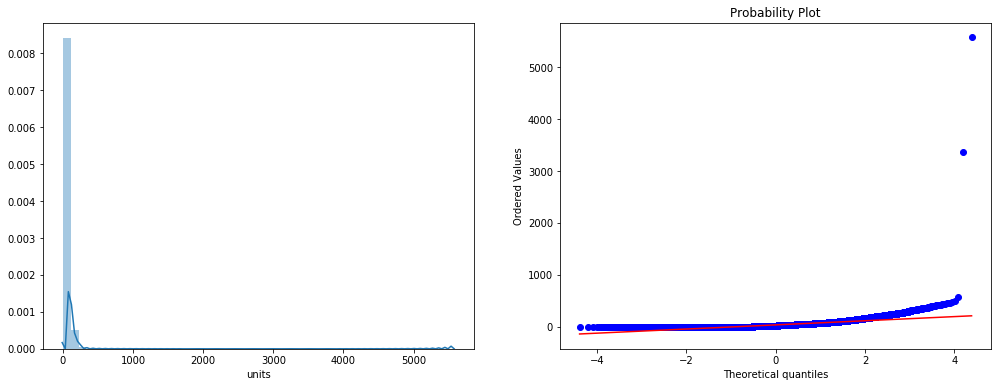

In [23]:
plt.figure(figsize=(17,6))

plt.subplot(121)
sns.distplot(all_data_result['units'])

plt.subplot(122)
stats.probplot(all_data_result['units'], plot=plt)

((array([-4.38348938, -4.1863337 , -4.07915671, ...,  4.07915671,
          4.1863337 ,  4.38348938]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.35957387, 8.12266802,
         8.62497078])),
 (1.3201640153772938, 2.9359016807354, 0.9679379642144903))

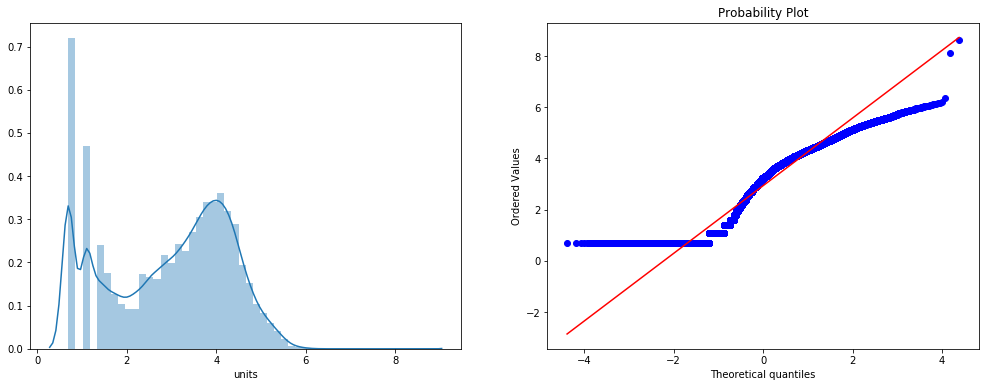

In [24]:
normalized = np.log1p(all_data_result['units'])

plt.figure(figsize=(17,6))

plt.subplot(121)
sns.distplot(normalized)

plt.subplot(122)
stats.probplot(normalized, plot=plt)


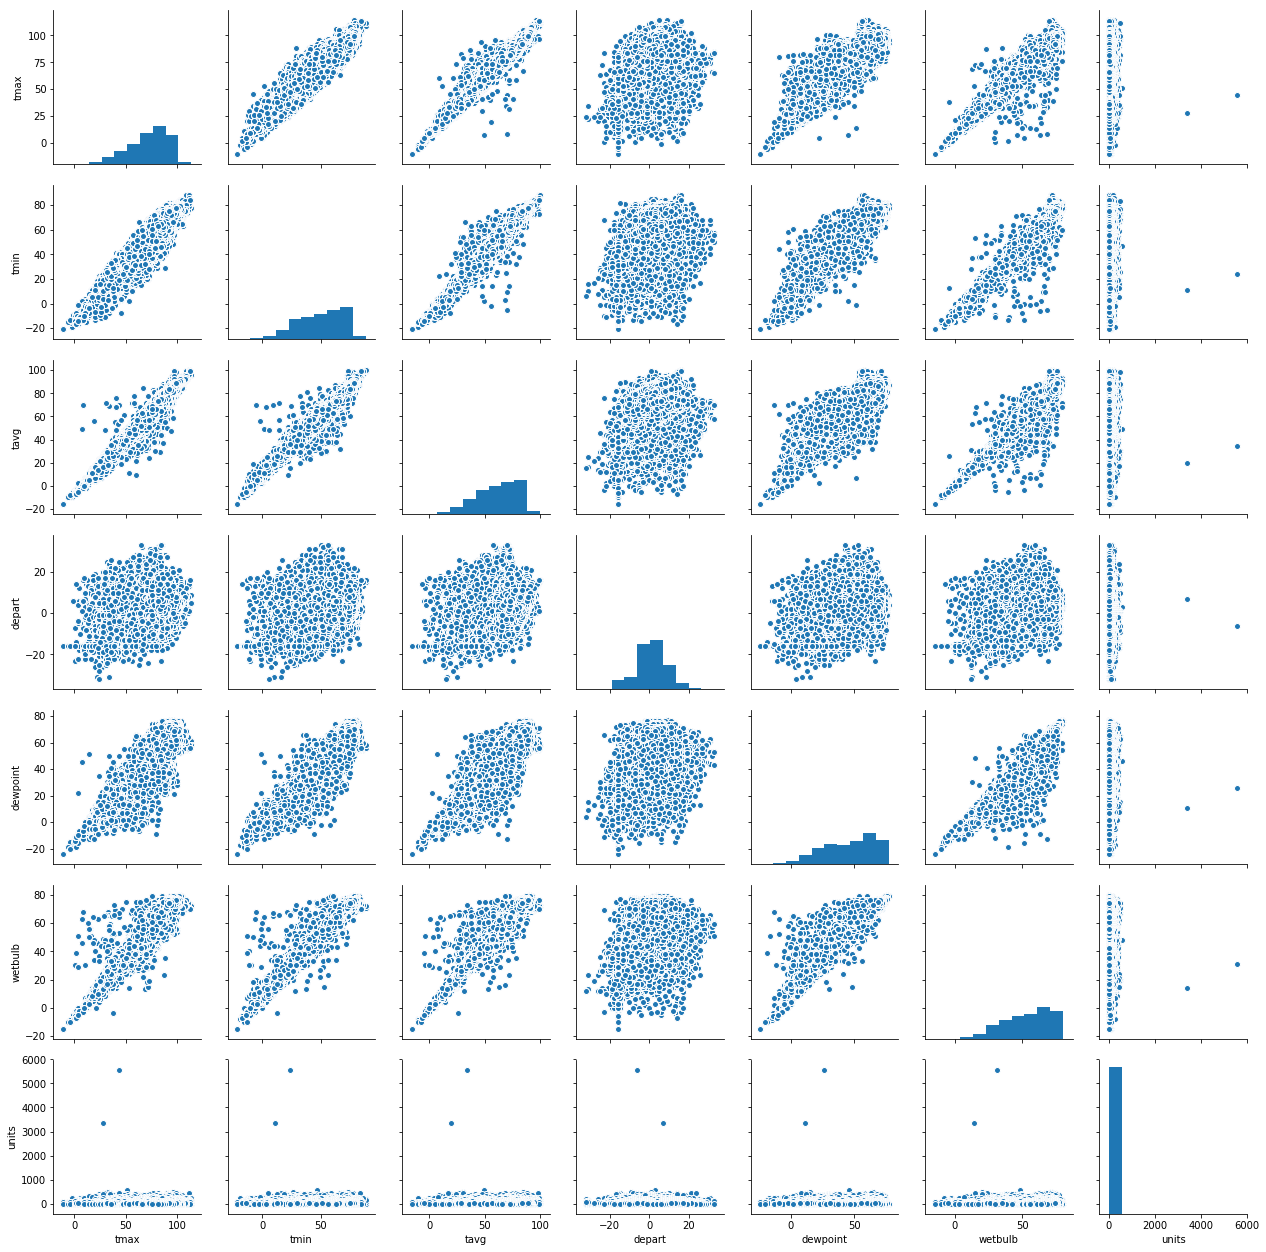

In [26]:
cols = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'units']
sns.pairplot(all_data_result[cols])
plt.show()

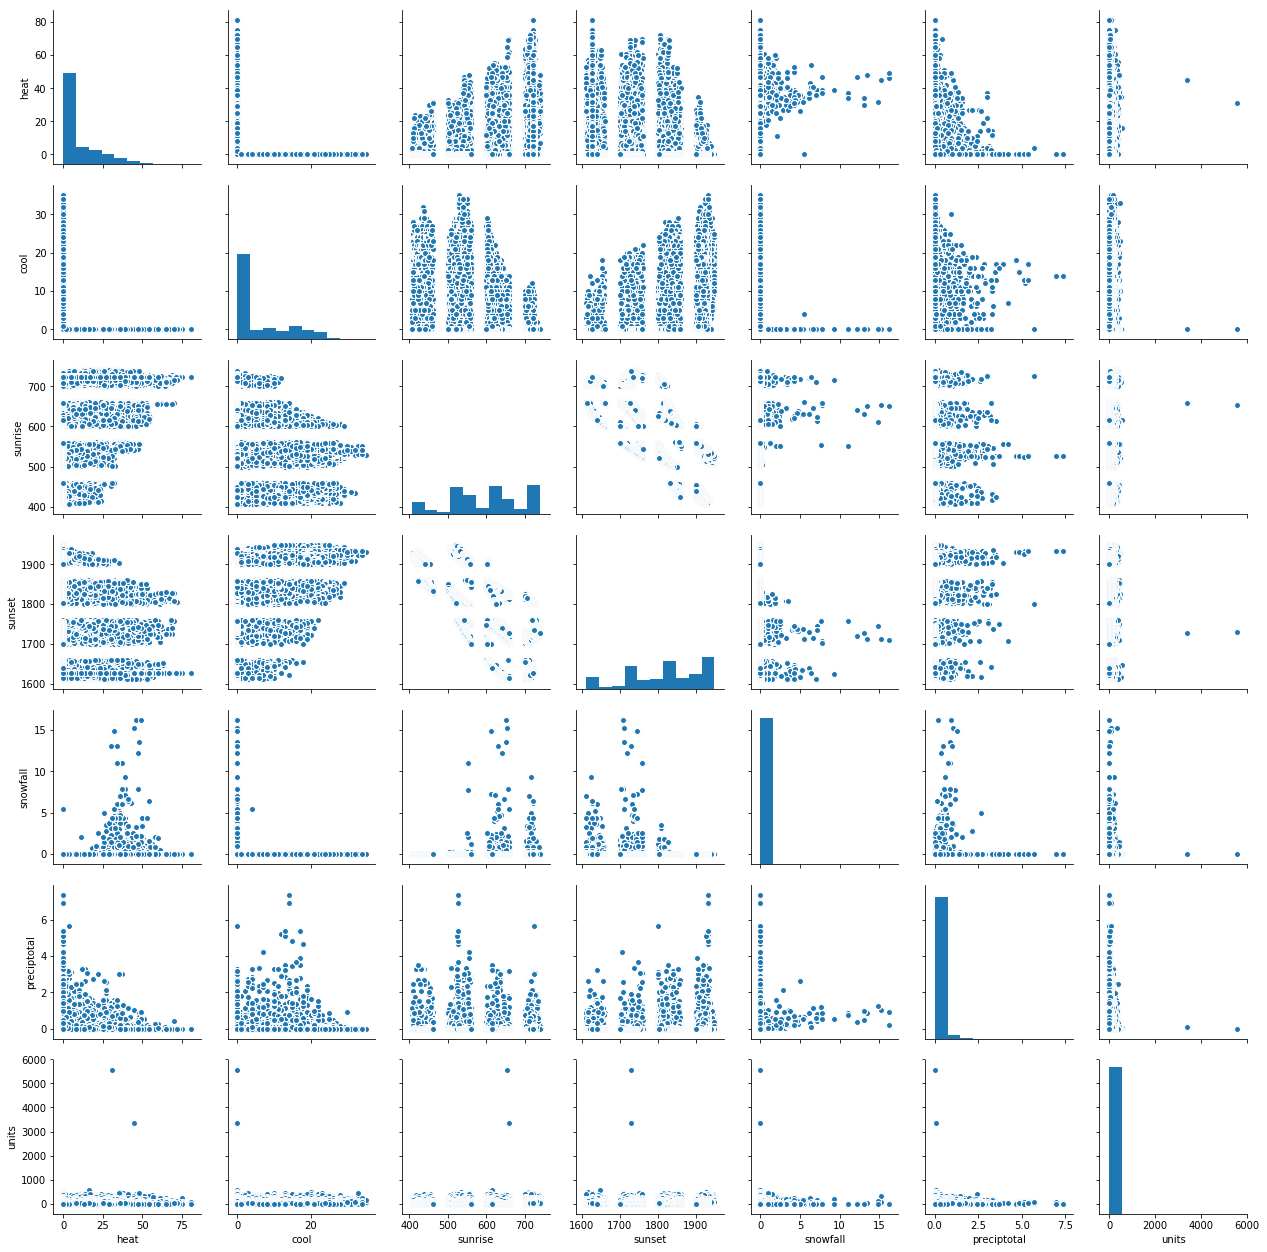

In [27]:
cols = ['heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal', 'units']
sns.pairplot(all_data_result[cols])
plt.show()

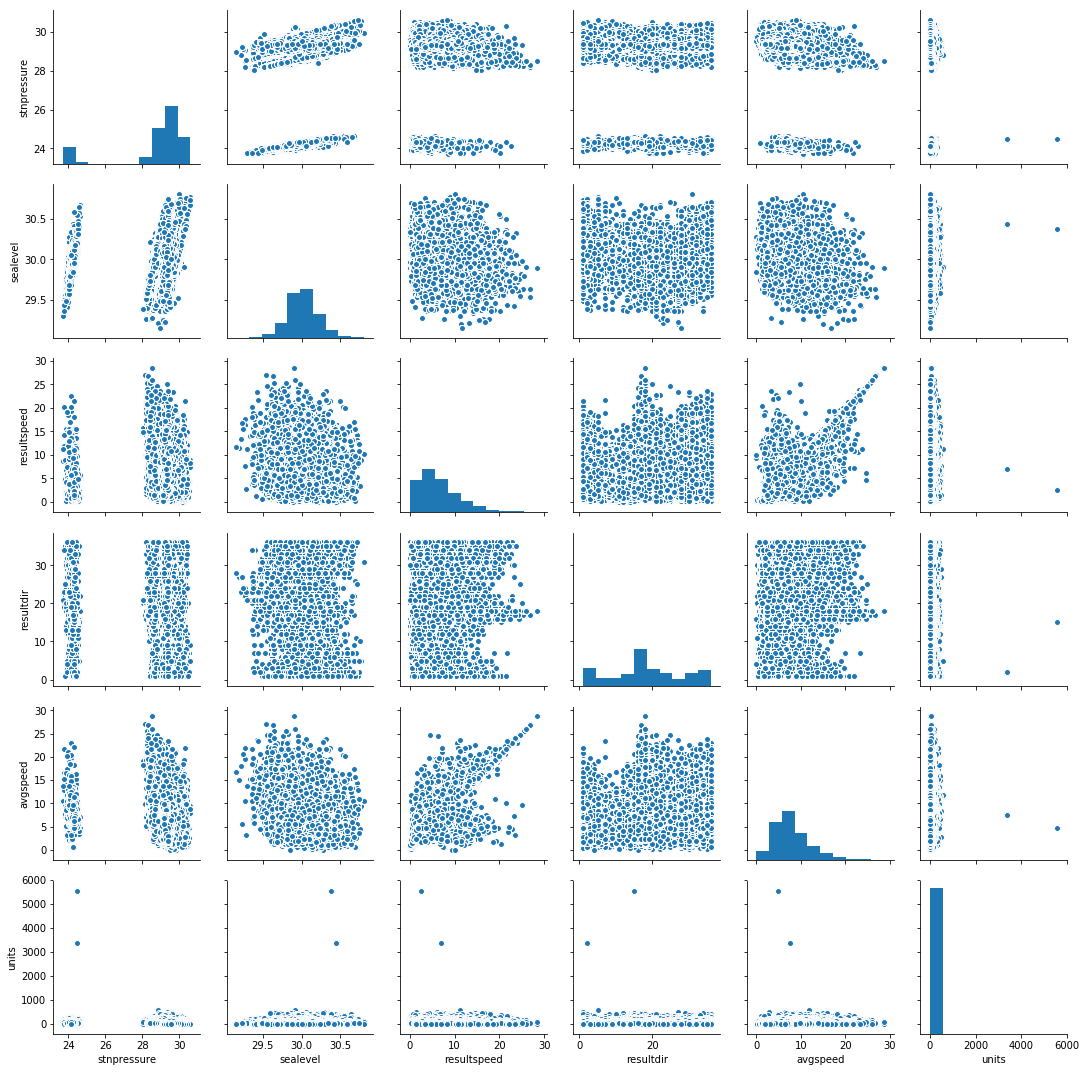

In [28]:
cols = ['stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'units']
sns.pairplot(all_data_result[cols])
plt.show()

## (2) Feature Selection

![image.png](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/feature%20selection.png?raw=true)

### Categorical variable analysis

![image.png](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/category%20variables.png?raw=true)

In [29]:
model_cat1 = sm.OLS.from_formula("units ~ C(weekday)", data=all_data_result)
sm.stats.anova_lm(model_cat1.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(weekday),6.0,2.757990e+06,459665.079758,196.852873,1.061156e-250
Residual,118689.0,2.771470e+08,2335.069193,NaN,NaN


In [30]:
model_cat2 = sm.OLS.from_formula("units ~ is_weekend", data=all_data_result)
sm.stats.anova_lm(model_cat2.fit())

,df,sum_sq,mean_sq,F,PR(>F)
is_weekend,1.0,2.098712e+06,2.098712e+06,896.684231,2.792975e-196
Residual,118694.0,2.778063e+08,2.340525e+03,NaN,NaN


In [31]:
model_cat3 = sm.OLS.from_formula("units ~ is_holiday", data=all_data_result)
sm.stats.anova_lm(model_cat3.fit())

,df,sum_sq,mean_sq,F,PR(>F)
is_holiday,1.0,1.759132e+03,1759.131717,0.745966,0.387758
Residual,118694.0,2.799033e+08,2358.192147,NaN,NaN


In [32]:
model_cat4 = sm.OLS.from_formula("units ~ is_holiday_weekday", data=all_data_result)
sm.stats.anova_lm(model_cat4.fit())

,df,sum_sq,mean_sq,F,PR(>F)
is_holiday_weekday,1.0,1.254688e+04,12546.883679,5.320757,0.021075
Residual,118694.0,2.798925e+08,2358.101260,NaN,NaN


In [33]:
model_cat5 = sm.OLS.from_formula("units ~ is_holiday_weekend", data=all_data_result)
sm.stats.anova_lm(model_cat5.fit())

,df,sum_sq,mean_sq,F,PR(>F)
is_holiday_weekend,1.0,1.176912e+04,11769.123141,4.990918,0.025483
Residual,118694.0,2.798932e+08,2358.107813,NaN,NaN


In [34]:
model_cat6 = sm.OLS.from_formula("units ~ C(day)", data=all_data_result)
sm.stats.anova_lm(model_cat6.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(day),30.0,2.259567e+06,75318.884867,32.191111,5.493002e-183
Residual,118665.0,2.776455e+08,2339.741721,NaN,NaN


In [35]:
model_cat7 = sm.OLS.from_formula("units ~ C(month)", data=all_data_result)
sm.stats.anova_lm(model_cat7.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(month),11.0,4.056500e+05,36877.275482,15.659222,4.292487e-31
Residual,118684.0,2.794994e+08,2354.987765,NaN,NaN


In [36]:
model_cat8 = sm.OLS.from_formula("units ~ C(year)", data=all_data_result)
sm.stats.anova_lm(model_cat8.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(year),2.0,1.048785e+06,524392.289431,223.203524,1.761062e-97
Residual,118693.0,2.788562e+08,2349.390725,NaN,NaN


In [37]:
model_cat9 = sm.OLS.from_formula("units ~ C(holiday_name)", data=all_data_result)
sm.stats.anova_lm(model_cat9.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(holiday_name),23.0,4.040858e+05,17568.948913,7.459518,1.112315e-24
Residual,118672.0,2.795009e+08,2355.239080,NaN,NaN


In [38]:
model_cat10 = sm.OLS.from_formula("units ~ C(around_BlackFriday)", data=all_data_result)
sm.stats.anova_lm(model_cat10.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(around_BlackFriday),7.0,1.734663e+05,24780.902591,10.514351,2.785542e-13
Residual,118688.0,2.797316e+08,2356.864650,NaN,NaN


In [39]:
model_cat11 = sm.OLS.from_formula("units ~ C(store_nbr)", data=all_data_result)
sm.stats.anova_lm(model_cat11.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(store_nbr),44.0,6.320322e+07,1.436437e+06,786.494034,0.0
Residual,118651.0,2.167018e+08,1.826380e+03,NaN,NaN


In [40]:
model_cat12 = sm.OLS.from_formula("units ~ C(item_nbr)", data=all_data_result)
sm.stats.anova_lm(model_cat12.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(item_nbr),110.0,1.161938e+08,1.056307e+06,765.141184,0.0
Residual,118585.0,1.637112e+08,1.380539e+03,NaN,NaN


In [41]:
model_cat13 = sm.OLS.from_formula("units ~ C(station_nbr)", data=all_data_result)
sm.stats.anova_lm(model_cat13.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(station_nbr),19.0,4.347878e+07,2.288357e+06,1148.658745,0.0
Residual,118676.0,2.364262e+08,1.992199e+03,NaN,NaN


### Numerical variables analysis: select 9 out of 17

![image.png](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/numerical%20variables.png?raw=true)

### Multicollinearity

In [42]:
# units, 일부 카테고리 변수 삭제한 데이터프레임 사용
lc = ['units', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
corr_df = all_data_result.filter(lc)

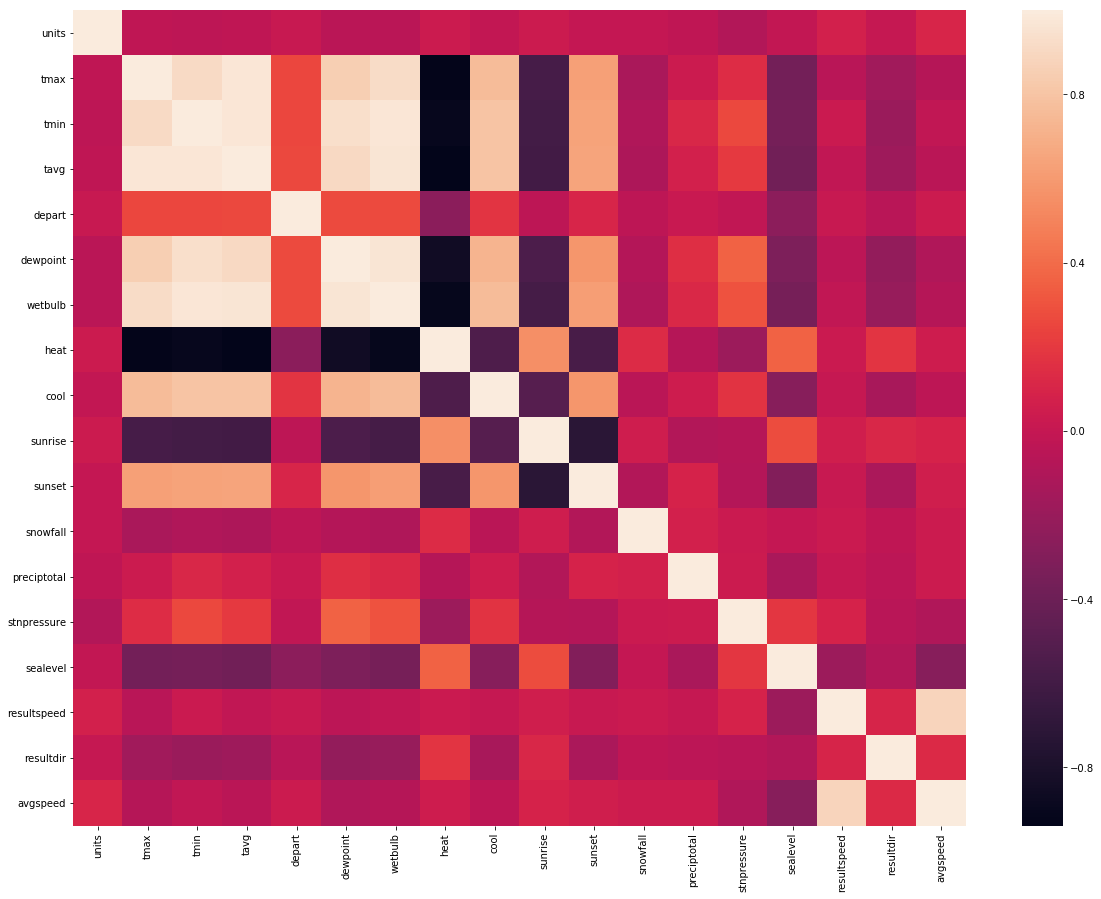

In [43]:
corr = corr_df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_df.corr())
plt.show()

### Selecting the most influential 9 numerical variables

In [44]:
cor = corr.nlargest(10, 'units')['units'].index
list(cor)

['units',
 'avgspeed',
 'resultspeed',
 'heat',
 'sunrise',
 'depart',
 'resultdir',
 'snowfall',
 'sunset',
 'sealevel']

### VIF

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df_columns = ['tamx', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
                 'heat', 'cool', 'sumrise', 'sunset', 'snowfall', 'preciptotal',
                 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
vif_df = all_data_result.filter(vif_df_columns)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
vif["features"] = vif_df.columns
vif.sort_values(ascending=False, by='VIF Factor')

,VIF Factor,features
1,36646.741977,tavg
5,2511.360676,heat
6,848.601139,cool
4,50.311893,wetbulb
0,29.881823,tmin
3,21.348363,dewpoint
14,5.834281,avgspeed
12,5.630098,resultspeed
7,2.014448,sunset
10,1.763956,stnpressure


## (3) Modeling 

### Modeling fuction

In [46]:
def formulaName(df, store):
    result = ""
    _df = df
    tmpPvalue = _df['P>|t|'].astype(float)
    tmpdf = _df[tmpPvalue < 0.1]
    ls = []
    tmp_store_df = tmpdf[tmpdf['store_nbr'] == store]
    Names = tmp_store_df.Name
    i = 0
    for Name in Names:
        i += 1
        if i < len(Names):
            result += Name + " "
        else:
            result += Name
    ls.append(result)
    return ls

def store_formulaList(Names):
    ls_result = []
    tmp_ls = Names
    a = ""
    for item in tmp_ls:
        i = 0
        words = item.split(" ")
        for word in words:
            i += 1
            if word.startswith("C(weekday)"):
                if a.find("C(weekday)") == -1:
                    a += "C(weekday) + "
            elif word.startswith("C(item_nbr)"):
                if a.find("C(item_ nbr)") == -1:
                    a += "C(item_nbr) + "
            elif word.startswith("C(month)"):
                if a.find("C(month)") == -1:
                    a += "C(month) + "
            elif word.startswith("C(day)"):
                if a.find("C(day)") == -1:
                    a += "C(day) + "     
            elif word.startswith("C(holiday_name)"):
                if a.find("C(holiday_name)") == -1:
                    a += "C(holiday_name) + " 
            elif word.startswith("C(around_BlackFriday)"):
                if a.find("C(around_BlackFriday)") == -1:
                    a += "C(around_BlackFriday) + "                     
            else:
                a += word + " + "

    return a[:-3]

def convert_store_formulaList(Names):
    ls_result = []
    tmp_ls = Names
    a = ""
    for item in tmp_ls:
        i = 0
        words = item.split(" ")
        for word in words:
            i += 1
            if word.startswith("C(weekday)"):
                if a.find("C(weekday)") == -1:
                    a += "C(weekday) + "
            elif word.startswith("C(item_nbr)"):
                if a.find("C(item_ nbr)") == -1:
                    a += "C(item_nbr) + "
            elif word.startswith("C(month)"):
                if a.find("C(month)") == -1:
                    a += "C(month) + "
            elif word.startswith("C(day)"):
                if a.find("C(day)") == -1:
                    a += "C(day) + "     
            elif word.startswith("C(holiday_name)"):
                if a.find("C(holiday_name)") == -1:
                    a += "C(holiday_name) + " 
            elif word.startswith("C(around_BlackFriday)"):
                if a.find("C(around_BlackFriday)") == -1:
                    a += "C(around_BlackFriday) + "                    
            else:
                a += word + " + "

    return a[:-3]


def store_test_predict(data, test_data, store, formulaList, f_convertList) :
    if formulaList == None:
        model = sm.OLS.from_formula( "np.log1p(units) ~ C(item_nbr) + C(weekday) +"
                                     "is_weekend + C(day) + C(month) +C(holiday_name) +"
                                     "C(around_BlackFriday) + depart + heat + sunrise +"
                                     "sunset + snowfall + sealevel + resultspeed + "
                                     "resultdir + avgspeed", data=result)
    else:
        model = sm.OLS.from_formula( "np.log1p(units) ~ " + formulaList , data=data)
    
    result_fit = model.fit()
    num_attr = ['store_nbr']
    num_attr.extend(f_convertList)
    
    test_predict = test_data[num_attr]
    
    result = result_fit.predict(test_predict)
    return result

In [47]:
def store_storage(result, store, formulaList) :
    """
    회귀분석 결과 모음

    전역변수로 아래 데이터 프레임 선언
    result_sets = pd.DataFrame(columns = ["R square", "AIC", "BIC", "P_fstatics", "P_omnibus", "P_jb", "Cond_no"])

    Variables_name.fit() 상태로 삽입
    ex)result = model.fit() 이면
    result를 삽입    


    reason = 이전 데이터 셋에서 무엇을 변화시켰는지 적을 것.
    """    
    
    global result_sets
    result_sets = pd.DataFrame(columns = ["store_nbr", "R square", "F_statics", "Prob(F_statics)", "AIC", "BIC",
                                          "Omnibus", "P_omnibus", "P_jb", "Cond_no"])

    if formulaList == None:
        model = sm.OLS.from_formula( "np.log1p(units) ~ C(item_nbr) + C(weekday) +"
                                     "is_weekend + C(day) + C(month) +C(holiday_name) +"
                                     "C(around_BlackFriday) + depart + heat + sunrise +"
                                     "sunset + snowfall + sealevel + resultspeed + "
                                     "resultdir + avgspeed", data=result)
    else:
        model = sm.OLS.from_formula( "np.log1p(units) ~ " + formulaList , data=result)

    result = model.fit()

    summary = result.summary()
    
    t1 = summary.tables[0]
    t2 = summary.tables[1]
    t3 = summary.tables[2]
    
    r_squared = float(t1.data[0][3])
    fstatics = float(t1.data[2][3])
    p_fstatics = float(t1.data[3][3])
    AIC = float(t1.data[5][3])
    BIC = float(t1.data[6][3])
    

    omnibus = float(t3.data[0][3])
    p_omnibus = float(t3.data[1][1])
    p_jb = float(t3.data[2][3])
    con = float(t3.data[3][3])

    put = {
        "store_nbr" : store,
        "R square" : r_squared,
        "F_statics" : fstatics,
        "Prob(F_statics)" : p_fstatics,
        "AIC" : AIC,
        "BIC" : BIC,
        "Omnibus" : omnibus,
        "P_omnibus" : p_omnibus,
        "P_jb" : p_jb,
        "Cond_no" : con,  
    }
    
    result_sets.loc[len(result_sets)] = put
    
    for i in range(2, len(t2)):
        result_sets = result_sets.append({
            "store_nbr" : store,
            "Name" : t2.data[i][0],
            "std err" : t2.data[i][2],
            "t" : t2.data[i][3],
            "P>|t|" : t2.data[i][4],
            "0.025" : t2.data[i][5],
            "0.975" : t2.data[i][6],
        }, ignore_index=True)
 
    return result_sets, result

In [48]:
def convertList(f_name):
    result = f_name.split(" + ")
    return result

In [49]:
def erase_outlier_np(result, data, category=False, dropped=False):
    """
    get the fitted model result, then erase outliers in data,
    by Fox' Outlier Recommendation.
    return arranged data, dropped data(when True)
    """

    influence = result.get_influence()

    if category:
        fox_cr = 4 / (len(data) - result.df_model + 1)
    else:
        fox_cr = 4 / (len(data) - result.df_model)

    cooks_d2, pvals = influence.cooks_distance
    idx = np.where(cooks_d2 > fox_cr)[0]

    dropped_data = data.iloc[idx]
    data = data.drop(data.index[idx])
    data.reset_index(drop=True, inplace=True)

    if dropped:

        return data, dropped_data

    return data

### OLS

In [50]:
model = sm.OLS.from_formula( "np.log1p(units) ~ C(store_nbr) + C(item_nbr) + C(weekday) +"
                             "is_weekend + C(day) + C(month) +C(holiday_name) +"
                             "C(around_BlackFriday) + depart + heat + sunrise +"
                             "sunset + snowfall + sealevel + resultspeed + "
                             "resultdir + avgspeed", data=all_data_result)

result = model.fit()
predict = result.predict(test_gg)

In [51]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log1p(units)   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     3141.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:02:59   Log-Likelihood:                -88281.
No. Observations:              118696   AIC:                         1.770e+05
Df Residuals:                  118462   BIC:                         1.793e+05
Df Model:                         233                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    1.8015      0.284      6.339      0.000       1.245       2.358
C(store_nbr)[T.2]                            0.6040      0.022     27.630      0.000       0.561       0.647
C(store_nbr)[T.3]                            0.4343      0.021     20.471      0.000       0.393       0.476
C(store_nbr)[T.4]                            1.1781      0.023     50.900      0.000       1.133       1.223
C(store_nbr)[T.5]                            0.1940      0.022      8.791      0.000       0.151       0.237
C(store_nbr)[T.6]                            0.4311      0.021     20.202      0.000       0.389       0.473
C(store_nbr)[T.7]                            0.6603      0.023     28.798      0.000       0.615       0.705
C(store_nbr)[T.8]                           -0.0276      0.023     -1.217      0.224      -0.072       0.017
C(store_nbr)[T.9]                            0.4229      0.019     21.907      0.000       0.385       0.461
C(store_nbr)[T.10]                           0.4911      0.021     23.343      0.000       0.450       0.532
C(store_nbr)[T.11]                           0.2662      0.021     12.689      0.000       0.225       0.307
C(store_nbr)[T.12]                           0.4768      0.022     21.801      0.000       0.434       0.520
C(store_nbr)[T.13]                           0.6113      0.022     27.206      0.000       0.567       0.655
C(store_nbr)[T.14]                          -0.8974      0.020    -44.895      0.000      -0.937      -0.858
C(store_nbr)[T.15]                           0.5230      0.020     25.924      0.000       0.483       0.563
C(store_nbr)[T.16]                           0.7250      0.021     34.349      0.000       0.684       0.766
C(store_nbr)[T.17]                           1.6132      0.020     82.618      0.000       1.575       1.651
C(store_nbr)[T.18]                          -0.2423      0.020    -12.021      0.000      -0.282      -0.203
C(store_nbr)[T.19]                           0.0363      0.022      1.618      0.106      -0.008       0.080
C(store_nbr)[T.20]                           0.6998      0.023     30.334      0.000       0.655       0.745
C(store_nbr)[T.21]                           0.2779      0.021     13.040      0.000       0.236       0.320
C(store_nbr)[T.22]                           0.3763      0.021     18.036      0.000       0.335       0.417
C(store_nbr)[T.23]                          -0.0593      0.020     -3.033      0.002      -0.098      -0.021
C(store_nbr)[T.24]                           1.5569      0.074     20.911      0.000       1.411       1.703
C(store_nbr)[T.25]                           0.7232      0.020     36.138      0.000       0.684       0.762
C(store_nbr)[T.26]             

### Modeling by each store : remove outliers

  0%|          | 0/45 [00:00<?, ?it/s]

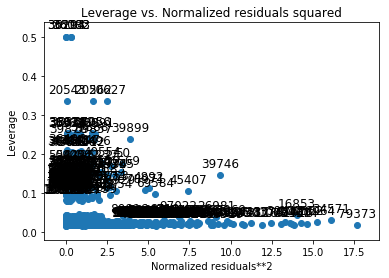

  2%|▏         | 1/45 [00:01<01:04,  1.46s/it]

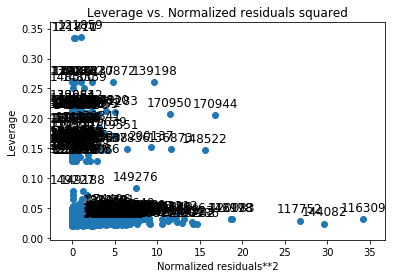

  4%|▍         | 2/45 [00:02<01:00,  1.40s/it]

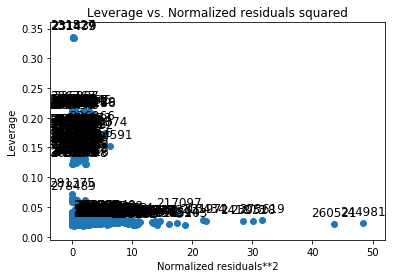

  7%|▋         | 3/45 [00:04<00:56,  1.35s/it]

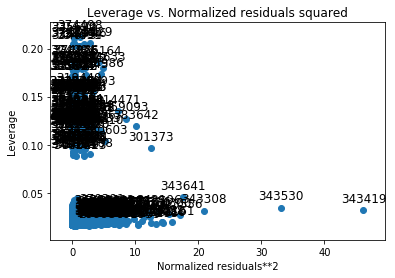

  9%|▉         | 4/45 [00:05<00:56,  1.38s/it]

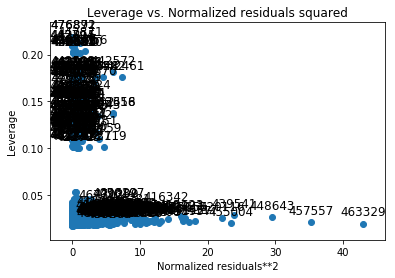

 11%|█         | 5/45 [00:06<00:55,  1.38s/it]

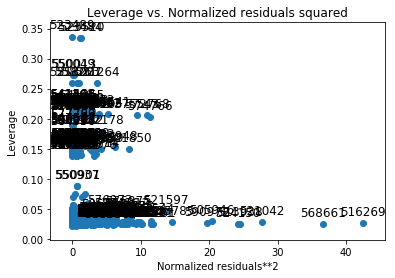

 13%|█▎        | 6/45 [00:08<00:52,  1.36s/it]

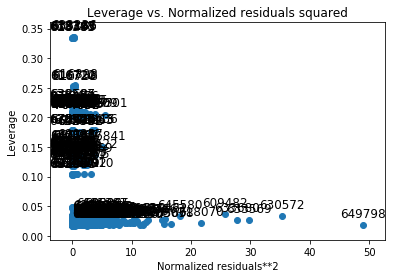

 16%|█▌        | 7/45 [00:09<00:51,  1.35s/it]

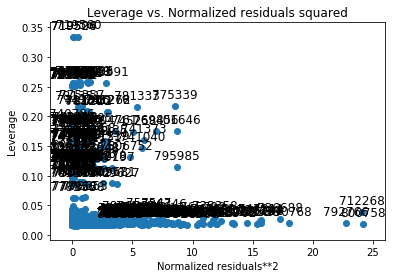

 18%|█▊        | 8/45 [00:10<00:50,  1.35s/it]

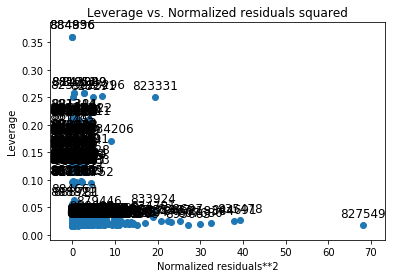

 20%|██        | 9/45 [00:12<00:49,  1.37s/it]

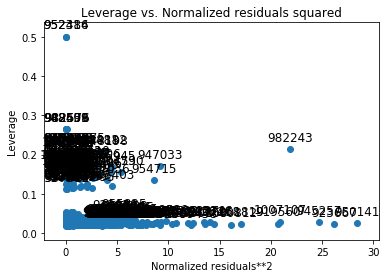

 22%|██▏       | 10/45 [00:13<00:48,  1.39s/it]

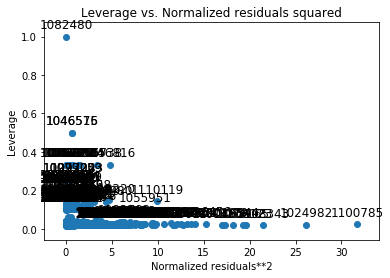

 24%|██▍       | 11/45 [00:15<00:48,  1.41s/it]

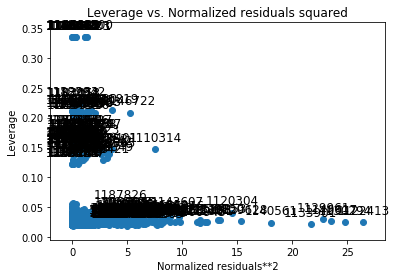

 27%|██▋       | 12/45 [00:16<00:46,  1.42s/it]

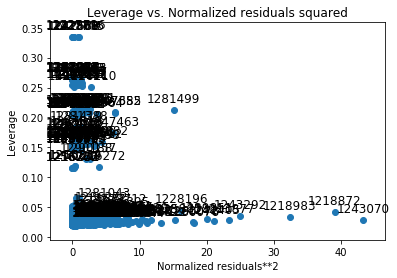

 29%|██▉       | 13/45 [00:18<00:44,  1.40s/it]

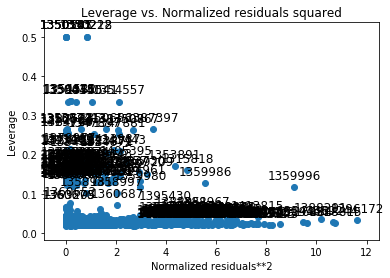

 31%|███       | 14/45 [00:19<00:43,  1.40s/it]

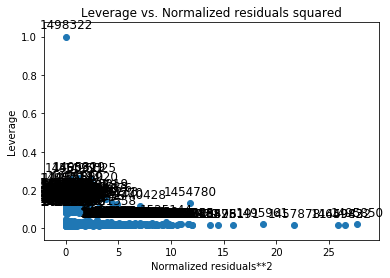

 33%|███▎      | 15/45 [00:21<00:42,  1.41s/it]

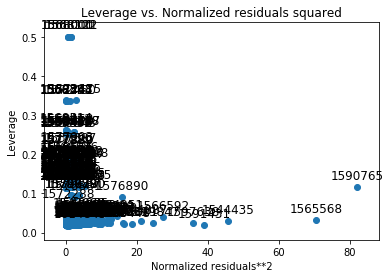

 36%|███▌      | 16/45 [00:22<00:40,  1.40s/it]

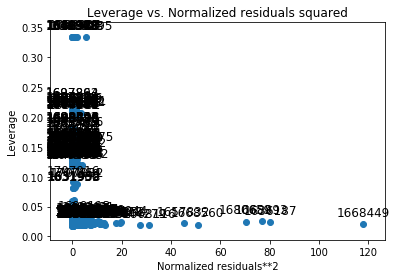

 38%|███▊      | 17/45 [00:23<00:38,  1.39s/it]

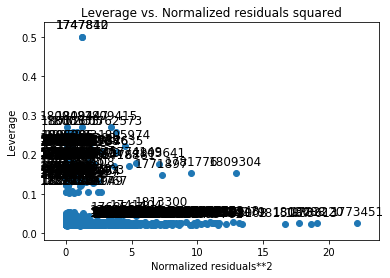

 40%|████      | 18/45 [00:25<00:37,  1.40s/it]

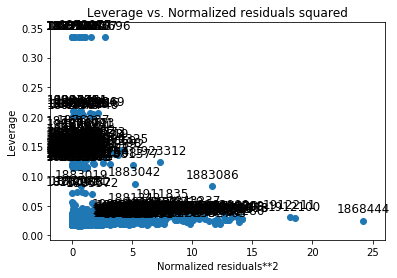

 42%|████▏     | 19/45 [00:26<00:36,  1.40s/it]

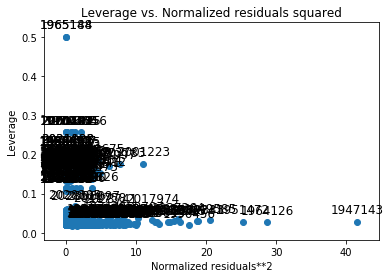

 44%|████▍     | 20/45 [00:28<00:35,  1.41s/it]

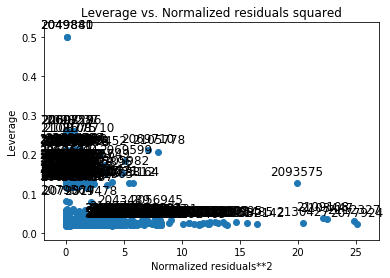

 47%|████▋     | 21/45 [00:29<00:33,  1.41s/it]

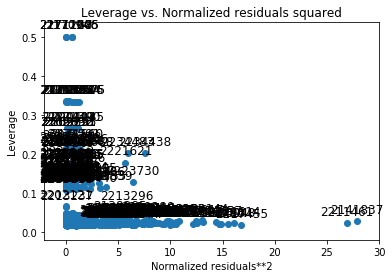

 49%|████▉     | 22/45 [00:31<00:32,  1.42s/it]

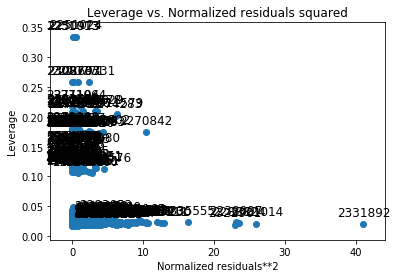

 51%|█████     | 23/45 [00:32<00:31,  1.42s/it]

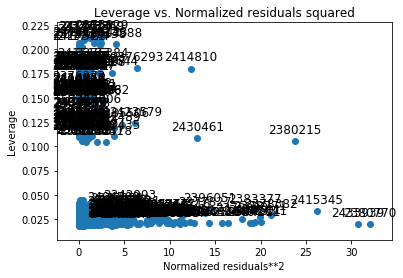

 53%|█████▎    | 24/45 [00:34<00:30,  1.43s/it]

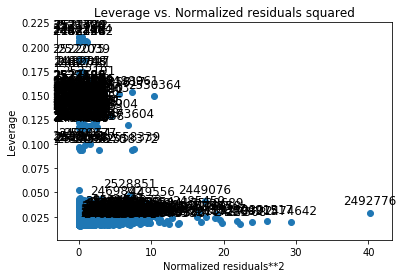

 56%|█████▌    | 25/45 [00:35<00:28,  1.44s/it]

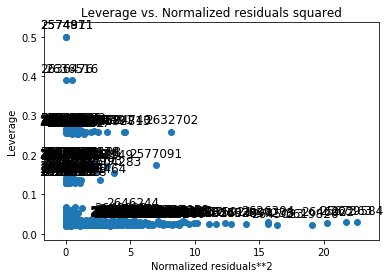

 58%|█████▊    | 26/45 [00:37<00:27,  1.43s/it]

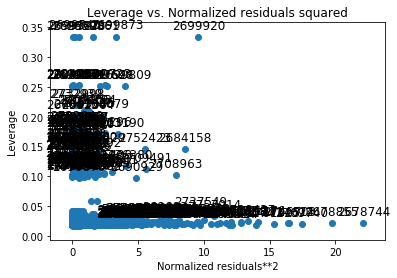

 60%|██████    | 27/45 [00:38<00:25,  1.42s/it]

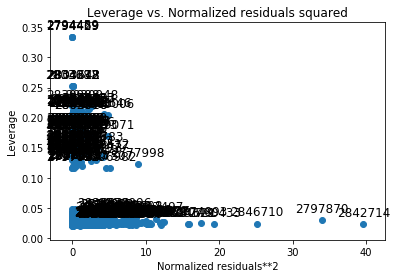

 62%|██████▏   | 28/45 [00:39<00:24,  1.42s/it]

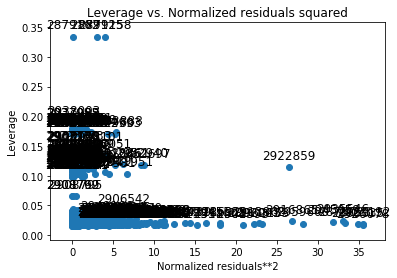

 64%|██████▍   | 29/45 [00:41<00:22,  1.42s/it]

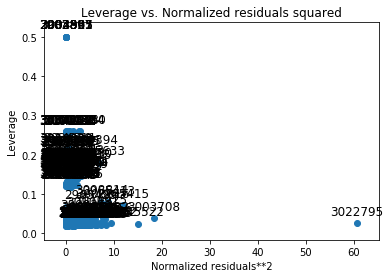

 67%|██████▋   | 30/45 [00:42<00:21,  1.41s/it]

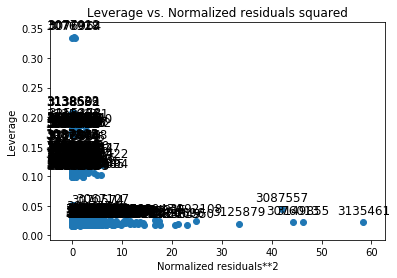

 69%|██████▉   | 31/45 [00:43<00:19,  1.42s/it]

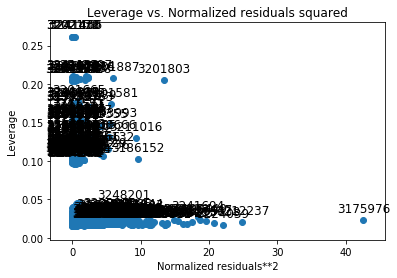

 71%|███████   | 32/45 [00:45<00:18,  1.42s/it]

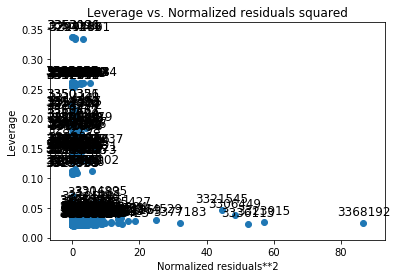

 73%|███████▎  | 33/45 [00:46<00:16,  1.42s/it]

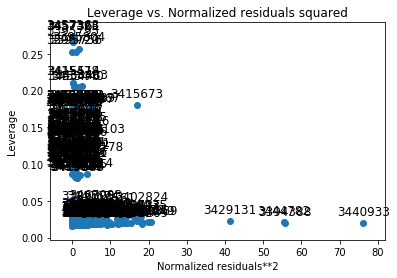

 76%|███████▌  | 34/45 [00:48<00:15,  1.42s/it]

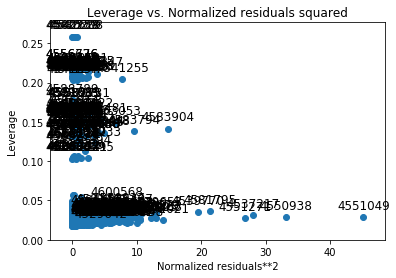

 78%|███████▊  | 35/45 [00:49<00:14,  1.42s/it]

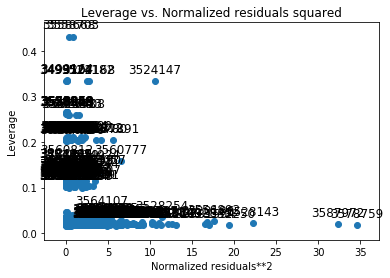

 80%|████████  | 36/45 [00:50<00:12,  1.41s/it]

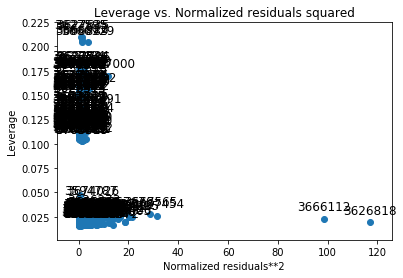

 82%|████████▏ | 37/45 [00:52<00:11,  1.42s/it]

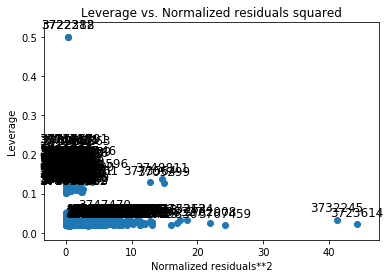

 84%|████████▍ | 38/45 [00:53<00:09,  1.42s/it]

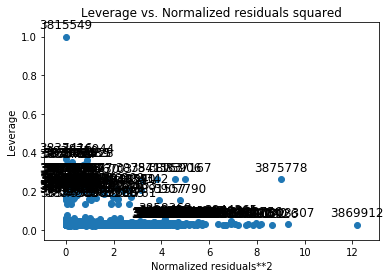

 87%|████████▋ | 39/45 [00:54<00:08,  1.41s/it]

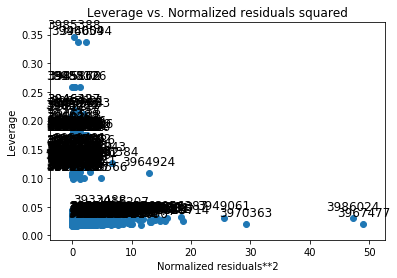

 89%|████████▉ | 40/45 [00:56<00:07,  1.41s/it]

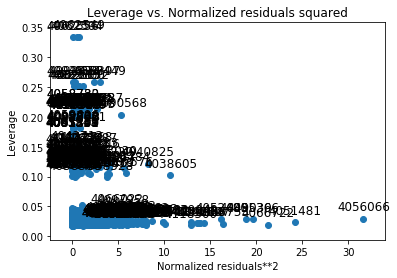

 91%|█████████ | 41/45 [00:57<00:05,  1.41s/it]

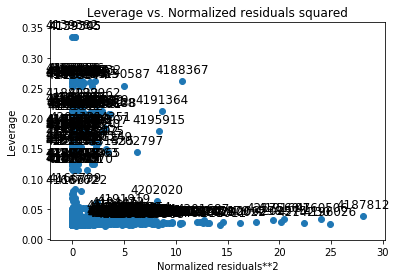

 93%|█████████▎| 42/45 [00:59<00:04,  1.41s/it]

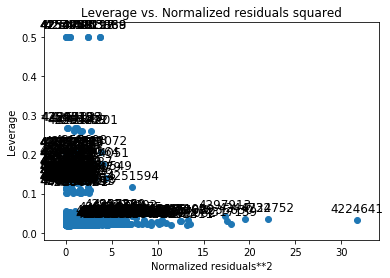

 96%|█████████▌| 43/45 [01:00<00:02,  1.40s/it]

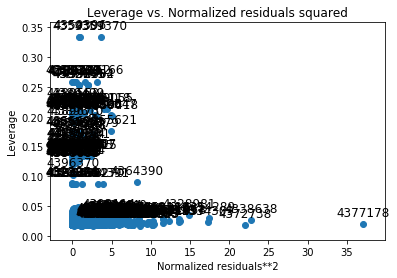

 98%|█████████▊| 44/45 [01:01<00:01,  1.40s/it]

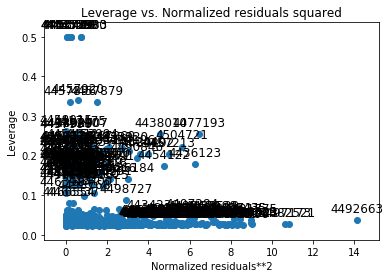

100%|██████████| 45/45 [01:03<00:00,  1.40s/it]


In [52]:
#1 _ store_nbr 기준으로 OLS 분석, 아웃라이어 제거
ls_store_nbr = set(all_data_result.store_nbr)
df = pd.DataFrame()
df_out = pd.DataFrame()
for store_nbr in tqdm(ls_store_nbr):
    data = all_data_result[all_data_result['store_nbr'] == store_nbr]
    #data = data[data['units'] > 0] 
    tmp_df, result = store_storage(data, store_nbr, None)
    df = df.append(tmp_df, ignore_index=True)
    temp = erase_outlier_np(result, data)
    df_out = df_out.append(temp, ignore_index=True)
    
    # 아웃라이어
    sm.graphics.plot_leverage_resid2(result)
    plt.show()

In [53]:
df_a = df.pivot_table(['R square'], index=['store_nbr'], aggfunc = 'sum')
df_a.tail()

,R square
store_nbr,
41.0,0.812
42.0,0.853
43.0,0.883
44.0,0.898
45.0,0.507


In [54]:
#2 _ 아웃라이어 제거 후 OLS 분석 --> p-value 제거안하고 predict
ls_store_nbr = set(all_data_result.store_nbr)
o_df = pd.DataFrame()
test_predict = pd.DataFrame()
for store_nbr in tqdm(ls_store_nbr):
    data = df_out[df_out['store_nbr'] == store_nbr]
    test_data = test_gg[test_gg['store_nbr'] == store_nbr]
    #data = data[data['units'] > 0]
#     f_list = formulaName(df, store_nbr)
    f_name = "item_nbr + weekday + is_weekend + tmax + tmin + depart + dewpoint + wetbulb + sunrise + sunset + snowfall + preciptotal + stnpressure + sealevel + resultspeed + resultdir + avgspeed"
    ff_name = "C(item_nbr) + C(weekday) + is_weekend + tmax + tmin + depart + dewpoint + wetbulb + sunrise + sunset + snowfall + preciptotal + stnpressure + sealevel + resultspeed + resultdir + avgspeed"
    f_convertList = convertList(f_name)
    tmp_df, result = store_storage(data, store_nbr, ff_name)
    tmp_predict = pd.DataFrame(data=store_test_predict(data, test_data,store_nbr, f_name, f_convertList))
    test_predict = test_predict.append(tmp_predict, ignore_index=True)
    o_df = o_df.append(tmp_df, ignore_index=True)    

100%|██████████| 45/45 [00:08<00:00,  5.34it/s]


In [55]:
df_b = o_df.pivot_table(['R square'], index=['store_nbr'], aggfunc = 'sum')
df_b.tail()

,R square
store_nbr,
41.0,0.838
42.0,0.880
43.0,0.877
44.0,0.917
45.0,0.559


## (4) Results

In [56]:
test_predict.head()
test_predict.to_csv('발표용 제출.csv', sep=',', index=False)

## (5) Kaggle Submission

![image.png](https://github.com/yunah0515/dss7_Crawling_walmart/blob/master/image/kaggle%20score.png?raw=true)

## (6) Refactoring